(week12:goes_temperature)=
# Comparing cloudtop and 11 $\mu m$ temperatures

## Introduction

In this notebook we look at the difference between the cloud top temperature (the variable `TEMP` in the product ABI-L2-ACHTF) and the Channel 14 11 $\mu m$ brightness
temperature (the variable CMI-C14 in the product ABI-L2-MCMIPC). 

We can only compare the two temperatures for cloud pixels, so we also need to get the
cloud mask, which is the variable `Cloud_Probabilities` in the product `ABI-L2-ACMC`.

Here is the list of [all GOES products](https://docs.opendata.aws/noaa-goes16/cics-readme.html)

It turns out that the cloud top temperature is only available hourly for the full disk, not the continental us.  As a result the closest times are different between the
cloud top temperature and channel 14 variables.  In the cells below we:

1. Read in the three datasets
2. Convert them to rioxarrays with transforms, crs, dims, coords
3. Crop all three to the same bounding box
4. Reproject cloud_top_temp to the same grid as Chan14 and the cloud mask.
5. Histogram the cloud_top_temp - Chan14 temperature difference for the masked pixels


**Question** Do you expect the cloudtop temperatures to be warmer, colder or the same
temperature as the Channel 14 window temperatures?

## Installation

- fetch and rebase to pick up the week12 folder with this ipynb file
- `pip install -r requirements.txt`  to install the newest version of the `a301_extras` library

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import pyproj
from matplotlib import pyplot as plt
import datetime
import pytz
import pandas as pd
from pyproj import CRS, Transformer
import affine
from a301_extras.sat_lib import make_new_rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature

running __init__.py


In [2]:
save_dir = Path.home() / "repos/a301/satdata/earthcare"

### set the time and bounding box corners

Copy these from {ref}`week12:goes_earthcare`

In [3]:
xmin = -145
xmax = -85.
ymin = 22.
ymax = 70
timestamp = pd.Timestamp('2024-12-13 22:50:35.447906')

## Find the nearest GOES MCMIP image

### Function get_goes

In [4]:
from goes2go import goes_nearesttime

def get_goes(timestamp, satellite="goes16", product="ABI-L2-MCMIP",domain="C",
             download=True, save_dir=None):
    g = goes_nearesttime(
        timestamp, satellite=satellite,product=product, domain=domain, 
          return_as="xarray", save_dir = save_dir, download = download, overwrite = False
    )
    the_path = g.path[0]
    return the_path

/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/goes2go/data.py:673: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/Users/phil/mini310/envs/a301/lib/python3.13/site-packages/goes2go/NEW.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


## Get the cloud top temperature

The variable `Temp` is in the `ABI-L2-ACHTF` product, at 2 km resolution.  It is available every 15 minutes, but only for the full disk. It is calculated by the same algorithm that computes the cloud top pressure and height.

In [5]:
download_dict = dict(satellite="goes18",product = "ABI-L2-ACHTF",domain="C",
                     save_dir=save_dir)

In [6]:
writeit = False
if writeit:
    the_path = get_goes(timestamp,**download_dict)
else:
    the_path = ('noaa-goes18/ABI-L2-ACHTF/2024/348/22/OR_ABI-L2-ACHTF-M6_G18_s20243482250209'
                '_e20243482259517_c20243482301529.nc'
               )
full_path = save_dir / the_path

In [7]:
the_path

'noaa-goes18/ABI-L2-ACHTF/2024/348/22/OR_ABI-L2-ACHTF-M6_G18_s20243482250209_e20243482259517_c20243482301529.nc'

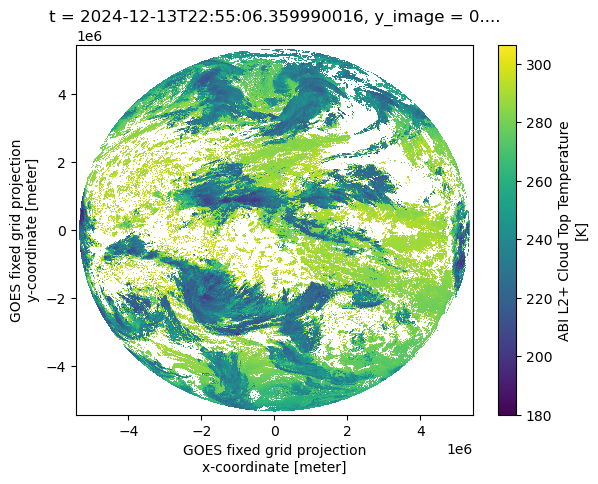

In [8]:
goes_ct = xr.open_dataset(full_path,mode = 'r',mask_and_scale = True)
cloud_temp = goes_ct.metpy.parse_cf('TEMP')
cloud_temp.plot.imshow();

## Get the cloud probability

The `Cloud_Probabilities` variable is in the `ABI-L2-ACMC ` product, at 2 km resolution.  It is available every 15 minutes. The
full description is [here](https://www.ospo.noaa.gov/data/messages/2021/11/MSG_20211118_1544.html).

In [9]:
download_dict = dict(satellite="goes18",product = "ABI-L2-ACMC",domain="C",
                     save_dir=save_dir)

In [10]:
writeit = False
if writeit:
    the_path = get_goes(timestamp,**download_dict)
else:
    the_path = ('noaa-goes18/ABI-L2-ACMC/2024/348/22/OR_ABI-L2-ACMC-M6_G18'
                '_s20243482251177_e20243482253550_c20243482254451.nc'
               )
full_path = save_dir / the_path

In [11]:
the_path

'noaa-goes18/ABI-L2-ACMC/2024/348/22/OR_ABI-L2-ACMC-M6_G18_s20243482251177_e20243482253550_c20243482254451.nc'

In [12]:
goes_mask = xr.open_dataset(full_path,mode = 'r',mask_and_scale = True)

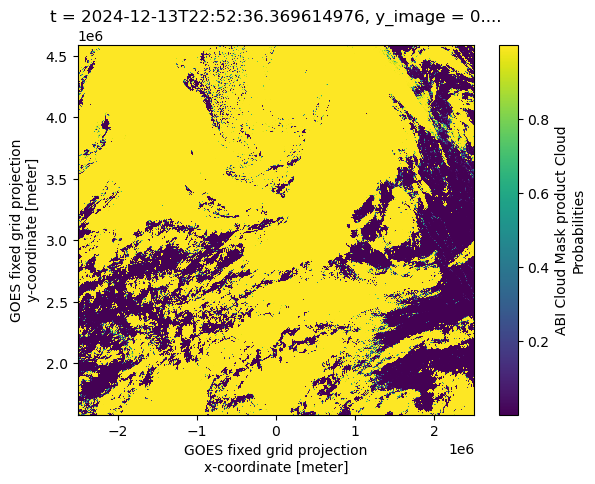

In [13]:
cloud_prob = goes_mask.metpy.parse_cf('Cloud_Probabilities')
cloud_prob.plot.imshow();

## Get the 11 micron thermal band -- channel 14

This is [channel 14](https://www.noaa.gov/jetstream/goes_east)  (CMI-C14) in the
moisture and cloud product MCMIPC.  The brightness temperature has 2 km resolution,
but unlike the `TEMP` variable, there is no atmospheric correction for water vapor above the cloud.

In [14]:
download_dict = dict(satellite="goes18",
                     product = "ABI-L2-MCMIPC",save_dir=save_dir)

In [15]:
writeit = False
if writeit:
    the_path = get_goes(timestamp,**download_dict)
else:
    the_path = ('noaa-goes18/ABI-L2-MCMIPC/2024/348/22/OR_ABI-L2-MCMIPC-M6_G18_s20243482251177'
                '_e20243482253562_c20243482254081.nc'
               )
full_path = save_dir / the_path
the_path

'noaa-goes18/ABI-L2-MCMIPC/2024/348/22/OR_ABI-L2-MCMIPC-M6_G18_s20243482251177_e20243482253562_c20243482254081.nc'

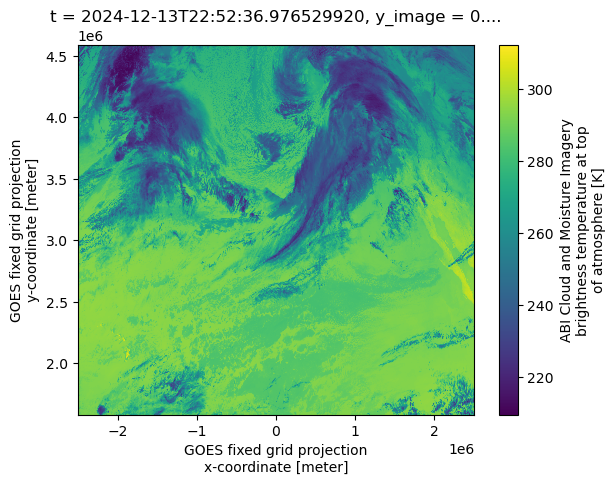

In [16]:
goes_mc = xr.open_dataset(full_path,mode = 'r',mask_and_scale = True)
chan_14 = goes_mc.metpy.parse_cf('CMI_C14')
chan_14.plot.imshow();

## Calculate the affine transforms

### Function get_affine

In [17]:
def get_affine(goes_da):
    resolutionx = np.mean(np.diff(goes_da.x))
    resolutiony = np.mean(np.diff(goes_da.y))
    ul_x = goes_da.x[0].data
    ul_y = goes_da.y[0].data
    goes_transform = affine.Affine(resolutionx, 0.0, ul_x, 0.0, resolutiony, ul_y)
    return goes_transform
    

### Note the cloud_temp affine transform has a diffrent resolution and corner coords

In [18]:
cloud_temp_affine = get_affine(cloud_temp)
chan_14_affine = get_affine(chan_14)
cloud_prob_affine = get_affine(cloud_prob)
chan_14_affine,  cloud_prob_affine, cloud_temp_affine

(Affine(np.float64(2004.017317102528), 0.0, np.float64(-2504019.637719609),
        0.0, np.float64(-2004.017295251391), np.float64(4588197.756226748)),
 Affine(np.float64(2004.017317102528), 0.0, np.float64(-2504019.637719609),
        0.0, np.float64(-2004.017295251391), np.float64(4588197.756226748)),
 Affine(np.float64(2004.0172201085857), 0.0, np.float64(-5433892.69232443),
        0.0, np.float64(-2004.0172201085857), np.float64(5433892.69232443)))

In [19]:
chan_14.shape, cloud_prob.shape, cloud_temp.shape

((1500, 2500), (1500, 2500), (5424, 5424))

## convert  cloud_temp  to a rioxarray

Use make_new_rioxarray introduced in {ref}`week8:goes_landsat_rio`

### Set the attributes

In [20]:
def get_goes_attributes(goes_da,title="no title", history="no history"):
    attribute_names=['long_name','standard_name','units','grid_mapping']
    attributes ={name:item for name,item in cloud_temp.attrs.items()
                 if name in attribute_names}
    attributes['history'] = f"{history}:{datetime.datetime.now()}"
    attributes['start'] = goes_ct.attrs['time_coverage_start']
    attributes['end'] = goes_ct.attrs['time_coverage_end']
    attributes['dataset'] = goes_ct.attrs['dataset_name']
    attributes['title'] = title
    return attributes

### Create the rioxarray

In [21]:
attributes = get_goes_attributes(cloud_temp, history="written by goes_temperature.ipynb",
                                 title="goes cloud top temperature (K)")
the_dims = ('y','x')
goes_crs = cloud_temp.metpy.pyproj_crs
coords_cloud_temp = dict(x=cloud_temp.x,y=cloud_temp.y)
cloud_temp_da = make_new_rioxarray(cloud_temp,
                                  coords_cloud_temp,
                                  the_dims,
                                  goes_crs,
                                  cloud_temp_affine,
                                  attrs = attributes,
                                  missing=np.float32(np.nan),
                                  name = 'ht')
                                                                   

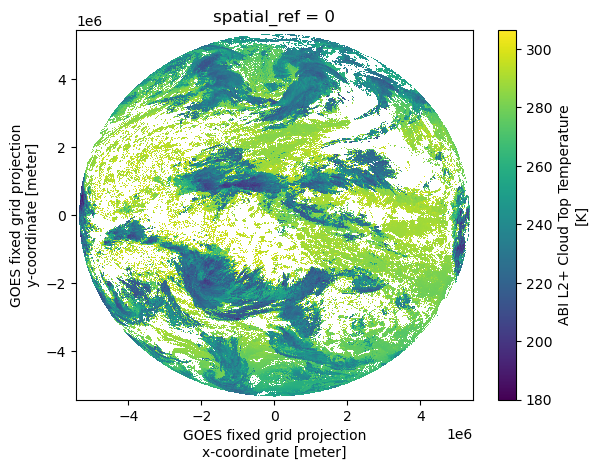

In [22]:
cloud_temp_da.plot.imshow()

## convert chan_14 to a rioxarray

### set chan_14 attributes

In [23]:
attributes = get_goes_attributes(cloud_temp, history="written by goes_temperature.ipynb",
                                 title="goes channel 14 brightness temperature (K)")
the_dims = ('y','x')
goes_crs = cloud_temp.metpy.pyproj_crs
coords_chan_14 = dict(x=chan_14.x,y=chan_14.y)
chan_14_da = make_new_rioxarray(chan_14,
                                  coords_chan_14,
                                  the_dims,
                                  goes_crs,
                                  chan_14_affine,
                                  attrs = attributes,
                                  missing=np.float32(np.nan),
                                  name = 'chan_14')
                                  

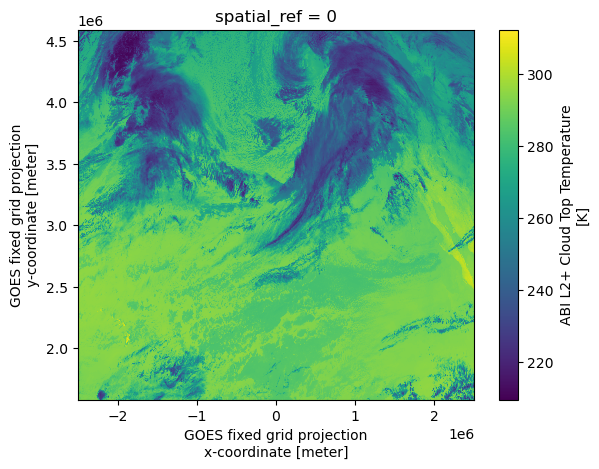

In [24]:
chan_14_da.plot.imshow();

## Convert cloud_prob to a rioxarray

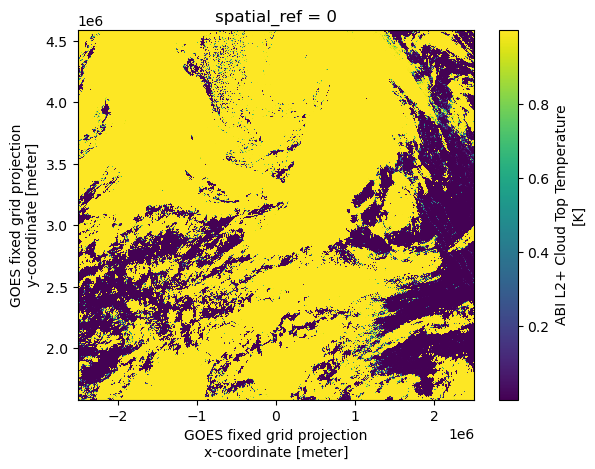

In [25]:
attributes = get_goes_attributes(cloud_temp, history="written by goes_temperature.ipynb",
                                 title="goes cloud probability")
the_dims = ('y','x')
goes_crs = cloud_prob.metpy.pyproj_crs
coords_cloud_prob = dict(x=cloud_prob.x,y=cloud_prob.y)
cloud_prob_da = make_new_rioxarray(cloud_prob,
                                  coords_cloud_prob,
                                  the_dims,
                                  goes_crs,
                                  cloud_prob_affine,
                                  attrs = attributes,
                                  missing=np.float32(np.nan),
                                  name = 'cloud_probability')
cloud_prob_da.plot.imshow() ;                                 

## crop the images

We want to crop the images to the west coast.  To do that, we first need to get
the bounding box in geostationary coordinates, so we can use the `rio.clip_box` function. We did this in week 8 in {ref}`week8:goes_clip_bounds`

### lon, lat bounds

In [26]:
xmin,ymin,xmax,ymax

(-145, 22.0, -85.0, 70)

### Transform the bounds from lat/lon to geostationary crs

Resulting image is 2304 km wide x 2861 km tall

In [27]:
#
# transform bounds from lat,lon to goes crs
#
latlon_crs = pyproj.CRS.from_epsg(4326)
transform = Transformer.from_crs(latlon_crs, goes_crs,always_xy=True)
xmin_goes,ymin_goes = transform.transform(xmin,ymin)
xmax_goes,ymax_goes = transform.transform(xmax,ymax)
print(f"{(xmax_goes - xmin_goes)=} m")
print(f"{(ymax_goes - ymin_goes)=} m")
bounds_goes = xmin_goes,ymin_goes,xmax_goes,ymax_goes

(xmax_goes - xmin_goes)=2304578.6198025653 m
(ymax_goes - ymin_goes)=2861053.251833326 m


### Crop using clip_box

Clip all three images to the same box

In [28]:
#
# now crop to these bounds using clip_box
#
clipped_cloud_temp=cloud_temp_da.rio.clip_box(*bounds_goes)
clipped_chan_14 = chan_14_da.rio.clip_box(*bounds_goes)
clipped_cloud_prob = cloud_prob_da.rio.clip_box(*bounds_goes)

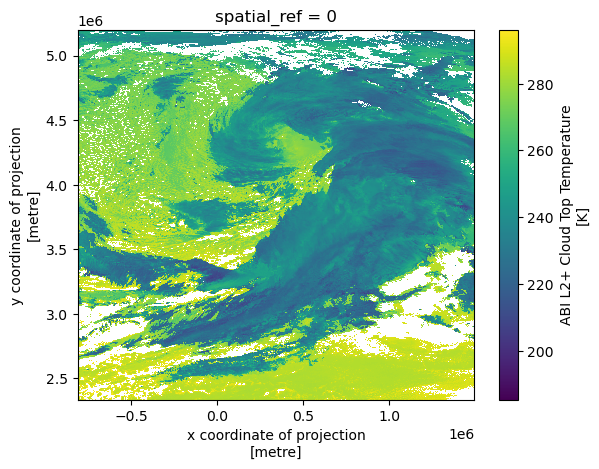

In [29]:
clipped_cloud_temp.plot.imshow()

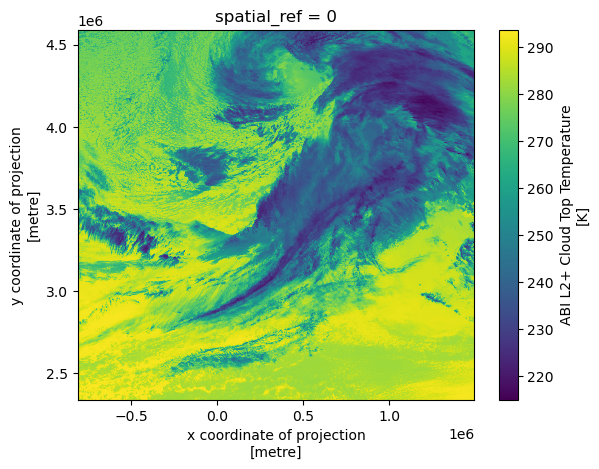

In [30]:
clipped_chan_14.plot.imshow()

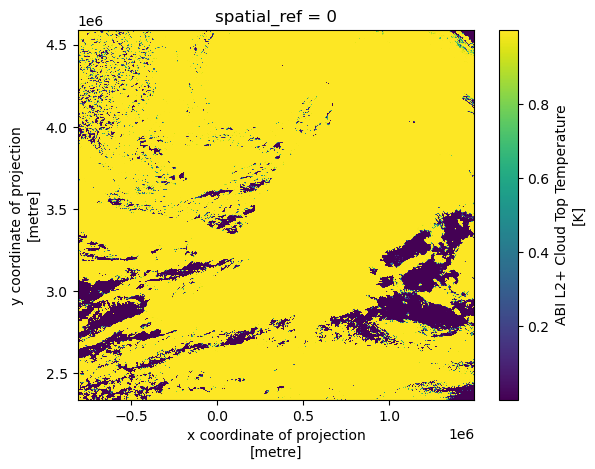

In [31]:
clipped_cloud_prob.plot.imshow()

### Again, note the cropped cloud_temp has a different shape and transform

In [32]:
clipped_cloud_temp.shape,clipped_chan_14.shape,clipped_cloud_prob.shape

((1428, 1151), (1124, 1151), (1124, 1151))

In [33]:
clipped_cloud_temp.rio.transform(),clipped_chan_14.rio.transform(),clipped_cloud_prob.rio.transform()

(Affine(2004.0173614498456, 0.0, -811627.0084341107,
        0.0, -2004.017459908606, 5198420.860140239),
 Affine(2004.0173614498456, 0.0, -811627.0084341107,
        0.0, -2004.0174118249295, 4589199.76493266),
 Affine(2004.0173614498456, 0.0, -811627.0084341107,
        0.0, -2004.0174118249295, 4589199.76493266))

## Use reproject_match to transform cloud_temp to same grid as clipped_chan14

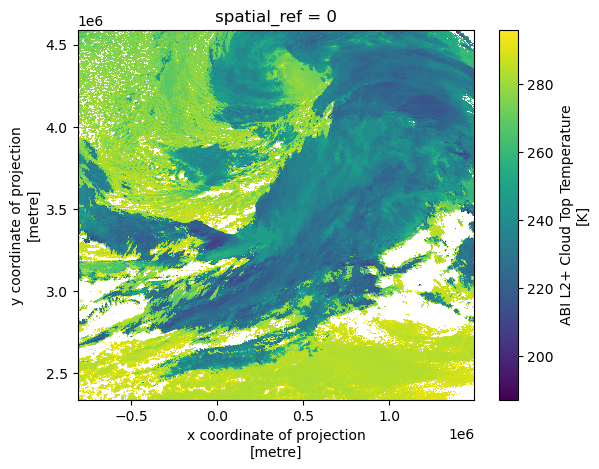

In [34]:
new_cloud_temp = clipped_cloud_temp.rio.reproject_match(clipped_chan_14)
new_cloud_temp.plot.imshow();

## apply the cloud mask

Mask all pixels that have less than a 99% chance of being cloudy

In [35]:
new_cloud_temp.data[clipped_cloud_prob < 0.99]=np.nan
clipped_chan_14.data[clipped_cloud_prob < 0.99] = np.nan

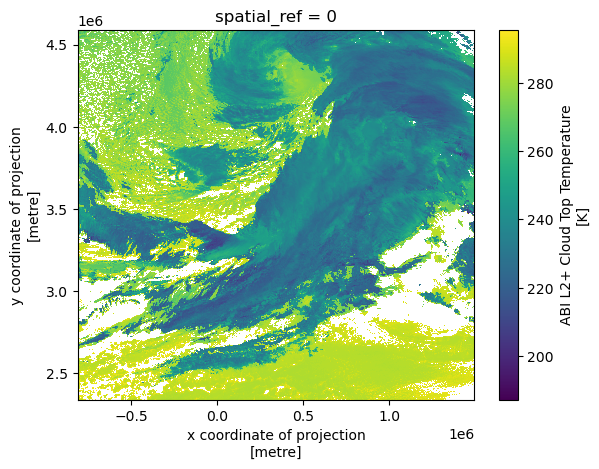

In [36]:
new_cloud_temp.plot.imshow();

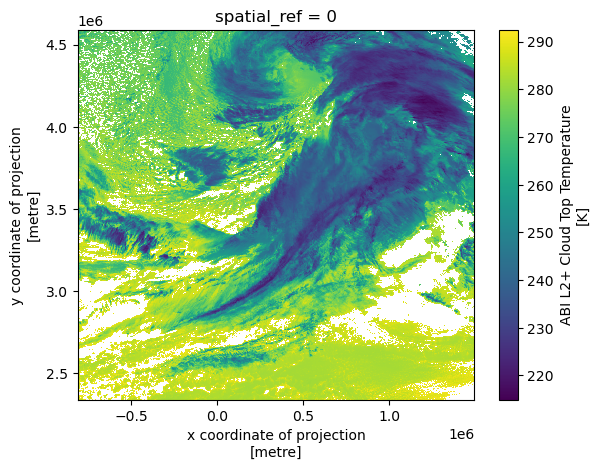

In [37]:
clipped_chan_14.plot.imshow();

## Find the cloud_temp - chan14 temperature difference

### Why are there large negative numbers?

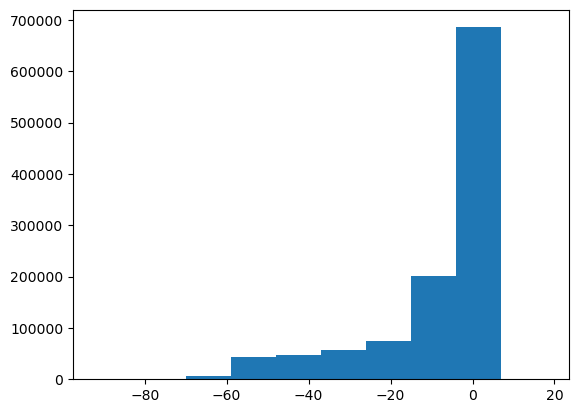

In [38]:
temp_diff = new_cloud_temp.data - clipped_chan_14.data
plt.hist(temp_diff.flat);

## Repeat, but only for positive differences

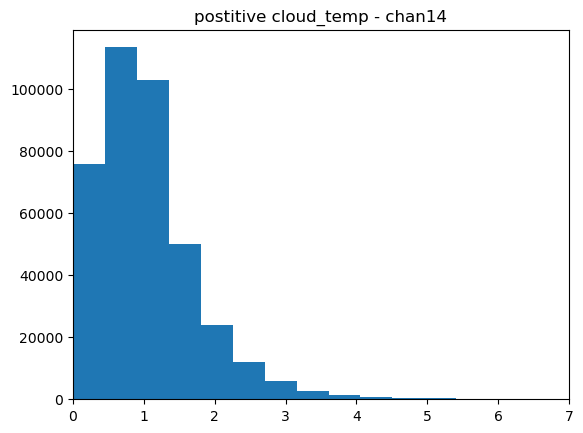

In [40]:
pos_temp_diff = temp_diff[temp_diff > 0.]
plt.hist(pos_temp_diff.flat,bins=40)
ax = plt.gca()
ax.set_xlim((0,7))
ax.set_title("postitive cloud_temp - chan14");